In [1]:
import time

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tqdm
import lightgbm as lgb

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

## Data Loading

In [3]:
df = pd.read_parquet("../data/curated/marts_downstream_houses.parquet")
df.head()

,id,price,installment,subdistrict,city,description,url,kamar_tidur,kamar_mandi,kamar_pembantu,...,hook,ruang_tamu,ruang_makan,terjangkau_internet,tags,facilities,house_materials,floor_materials,image_urls,amenities
0,hos14264153,3.190000e+09,14000000.0,Babakanmadang,Bogor,Welcome investor \nDepan Taman Yang Luas dan B...,https://www.rumah123.com/properti/bogor/hos142...,4,4,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, perumahan, komplek]","[ac, keamanan, taman, laundry, wastafel, ac]","[beton, bata_merah]","[keramik, ubin]",[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
1,hos15848009,1.730000e+09,7000000.0,Babakanmadang,Bogor,"Rumah Berada Di Klaster TerDepan , Dekat Denga...",https://www.rumah123.com/properti/bogor/hos158...,2,1,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, taman, laundry, parkir, keaman...","[beton, bata_merah]",[keramik],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
2,hos15802277,4.200000e+09,19000000.0,Babakanmadang,Bogor,Beberapa alasan mengapa membeli property di ka...,https://www.rumah123.com/properti/bogor/hos158...,3,4,1,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, kolam_renang, laundry, keamana...",[bata_merah],[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
3,hos15998766,1.100000e+09,5000000.0,Babakanmadang,Bogor,Rumah Dijual Tipe Scandinavian Siap Huni Full ...,https://www.rumah123.com/properti/bogor/hos159...,3,1,0,...,0,1,1,1,"[bisa_nego, cash_keras, kpr, one_gate_system, ...","[jalur_telepon, laundry, keamanan, masjid, one...",[bata_merah],[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."
4,hos16024616,3.250000e+09,14000000.0,Babakanmadang,Bogor,Dijual rumah dengan kolam renang dan 5 kamar t...,https://www.rumah123.com/properti/bogor/hos160...,5,5,1,...,0,1,1,1,"[bisa_nego, cash_keras, one_gate_system, perum...","[jalur_telepon, kolam_renang, taman, laundry, ...","[bata_merah, bata_hebel]",[granit],[https://picture.rumah123.com/r123-images/720x...,"{'sustenance': 2.0, 'facilities': 1.0, 'educat..."


## Preprocessing

In [4]:
def preprocess_data(df_ori: pd.DataFrame) -> pd.DataFrame:
    # select columns
    multichoice_cols = ["house_materials", "floor_materials", "tags", "facilities", "amenities"]
    drop_col = ["id", "installment", "city", "description", "url", "tipe_properti", "image_urls", "hadap"] + multichoice_cols

    df_data = df_ori.drop(columns=drop_col).copy()

    # IQR-based outlier removal
    # q1 = df_data["price"].quantile(0.25)
    # q3 = df_data["price"].quantile(0.75)
    # iqr = q3 - q1

    # df_data = df_data[(df_data["price"] > (q1 - 1.5*iqr)) & (df_data["price"] < (q3 + 1.5*iqr))]

    # log-tranform price
    df_data["price"] = np.log(df_data["price"])

    # derive new features
    df_data["land_building_ratio"] = df_data["luas_tanah"] / df_data["luas_bangunan"]
    df_data["total_beds"] = df_data["kamar_tidur"] + df_data["kamar_pembantu"]
    df_data["total_baths"] = df_data["kamar_mandi"] + df_data["kamar_mandi_pembantu"]
    df_data["bed_bath_ratio"] = df_data["kamar_tidur"] / df_data["kamar_mandi"]
    df_data["total_bed_bath_ratio"] = df_data["total_beds"] / df_data["total_baths"]
    df_data["rennovated_built_diff"] = df_data["tahun_di_renovasi"] - df_data["tahun_dibangun"]
    df_data["building_area_floor_ratio"] = df_data["luas_bangunan"] / df_data["jumlah_lantai"]
    df_data["vehicle_accessibility"] = (df_data["garasi"] + df_data["carport"]) / df_data["lebar_jalan"]

    # convert categorical columns
    cat_cols = df_data.select_dtypes("object").columns.tolist() + ["hook", "ruang_tamu", "ruang_makan", "terjangkau_internet"]
    df_data = df_data.fillna(value={k: "" for k in cat_cols})
    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data

In [5]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=22)

In [6]:
df_train_proc = preprocess_data(df_train)
df_test_proc = preprocess_data(df_test)

X_train, y_train = df_train_proc.drop(columns=["price"]), df_train_proc["price"]
X_test, y_test = df_test_proc.drop(columns=["price"]), df_test_proc["price"]

cat_cols = X_train.select_dtypes("category").columns.tolist()

## Cross-Validation

In [7]:
n_splits = 5
cv_results = []

cv = KFold(n_splits=n_splits, shuffle=True, random_state=22)
for (train_idx, val_idx) in tqdm.tqdm(cv.split(X_train), total=n_splits):
    # split data
    X_train_cv, y_train_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
    
    # train model
    fit_time_start = time.time()
    model = lgb.LGBMRegressor(seed=22, verbosity=-1)
    model.fit(X_train_cv, y_train_cv, categorical_feature=cat_cols)
    fit_time_end = time.time()

    # run predictions
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    score_time_start = time.time()
    y_pred = model.predict(X_val)
    score_time_end = time.time()

    # store metrics
    cv_results.append({
        "fit_time": fit_time_end - fit_time_start,
        "score_time": score_time_end - score_time_start,
        
        "r2": r2_score(y_val, y_pred),
        "mse": mean_squared_error(y_val, y_pred),
        "mae": mean_absolute_error(y_val, y_pred),
        "mape": mean_absolute_percentage_error(y_val, y_pred),
        "smape": smape(y_val, y_pred),
    })

df_cv = pd.DataFrame(cv_results)
df_cv.round(5)

100%|██████████| 5/5 [00:00<00:00,  7.46it/s]


,fit_time,score_time,r2,mse,mae,mape,smape
0,0.13633,0.00663,0.90093,0.12205,0.23747,0.01130,0.01128
1,0.13389,0.00783,0.84095,0.20411,0.24987,0.01208,0.01193
2,0.11020,0.00707,0.91035,0.10925,0.22398,0.01071,0.01068
3,0.11206,0.00706,0.87004,0.16721,0.24350,0.01160,0.01158
4,0.11329,0.00683,0.90032,0.12559,0.22806,0.01083,0.01083


In [8]:
df_cv.describe().round(5)

,fit_time,score_time,r2,mse,mae,mape,smape
count,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000
mean,0.12115,0.00708,0.88452,0.14564,0.23658,0.01131,0.01126
std,0.01282,0.00045,0.02870,0.03926,0.01068,0.00056,0.00052
min,0.11020,0.00663,0.84095,0.10925,0.22398,0.01071,0.01068
25%,0.11206,0.00683,0.87004,0.12205,0.22806,0.01083,0.01083
50%,0.11329,0.00706,0.90032,0.12559,0.23747,0.01130,0.01128
75%,0.13389,0.00707,0.90093,0.16721,0.24350,0.01160,0.01158
max,0.13633,0.00783,0.91035,0.20411,0.24987,0.01208,0.01193


## Hold-out Evaluation

In [9]:
model = lgb.LGBMRegressor(seed=22)
model.fit(X_train, y_train, categorical_feature=cat_cols)

y_pred = model.predict(X_test)

In [10]:
print("R2", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("MAPE", mean_absolute_percentage_error(y_test, y_pred))
print("sMAPE", smape(y_test, y_pred))

R2 0.9051007993908762
MAE 0.23159701645060027
MSE 0.11886513721016245
MAPE 0.01106385347464695
sMAPE 0.011048323464296097


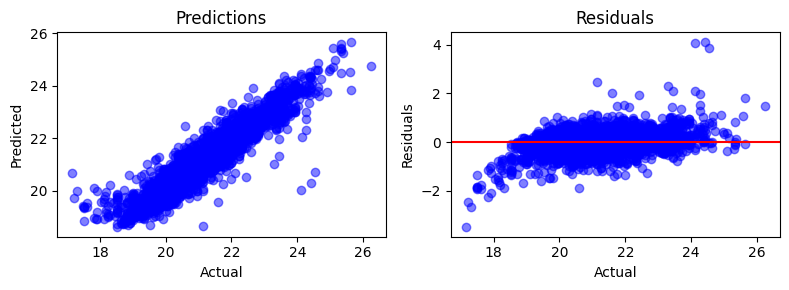

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(y_test, y_pred, color="blue", alpha=0.5)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].set_title("Predictions")

ax[1].scatter(y_test, y_test - y_pred, color="blue", alpha=0.5)
ax[1].axhline(y=0, color="r", linestyle="-")
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")

fig.tight_layout()
plt.show()

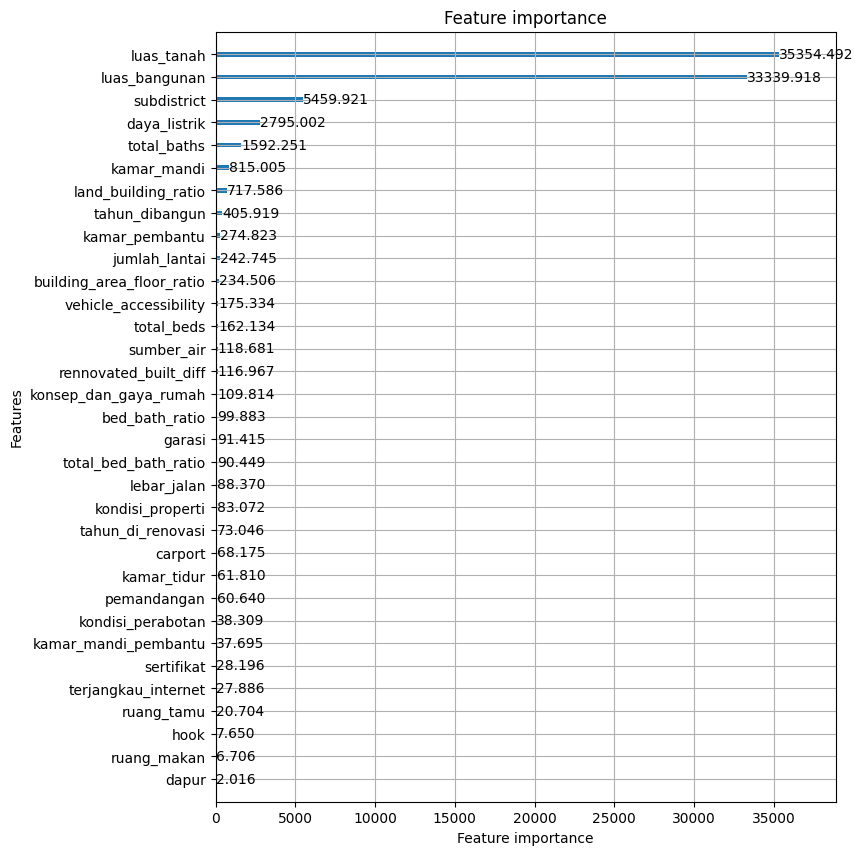

In [12]:
fig, ax = plt.subplots(figsize=(8, 10))
lgb.plot_importance(model, importance_type="gain", ax=ax)
plt.show()

## Feature Selection - Boruta

- https://medium.com/geekculture/boruta-feature-selection-explained-in-python-7ae8bf4aa1e7
- https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596/
- https://github.com/scikit-learn-contrib/boruta_py/blob/master/boruta/boruta_py.py#L490
- https://github.com/edikedik/eBoruta/blob/master/eBoruta/algorithm.py

In [13]:
alpha = 0.05
n_trials = 50
mzsa_perc = 100

rng = np.random.default_rng(123456)
feature_hits = {k: 0 for k in df_train_proc.columns}


for run_num in tqdm.tqdm(range(n_trials)):
    # copy dataframe
    df_train_boruta = df_train_proc.copy()
    X_boruta, y_boruta = df_train_boruta.drop(columns=["price"]), df_train_boruta["price"]

    # create shadow features
    for col in X_boruta.columns:
        X_boruta[f"shadow_{col}"] = X_boruta[col].sample(frac=1.0, replace=False, random_state=rng).values

    # train model
    model = lgb.LGBMRegressor(seed=rng.integers(1, 99999), verbosity=-1)
    model.fit(X_boruta, y_boruta, categorical_feature=cat_cols)

    # get feature importances
    importances = {k:v for k, v in zip(X_boruta.columns, model.booster_.feature_importance(importance_type="gain"))}
    mzsa_threshold = np.percentile([v for k, v in importances.items() if "shadow_" in k], mzsa_perc)

    selected_features = [k for k, v in importances.items() if "shadow_" not in k and v > mzsa_threshold]
    for k in selected_features:
        feature_hits[k] += 1

    # calculate significance with Bonferoni correction
    hits = np.array(list(feature_hits.values()))
    to_accept = sp.stats.binom.sf(hits - 1, run_num, .5) <= alpha / len(feature_hits)
    to_reject = sp.stats.binom.cdf(hits, run_num, .5) <= alpha / len(feature_hits)

    if np.all(np.bitwise_or(to_accept, to_reject)):
        print("Early stopping!")
        break

100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


In [14]:
feat_accept = np.array(list(feature_hits.keys()))[to_accept]
feat_reject = np.array(list(feature_hits.keys()))[to_reject]

def get_feat_status(name: str):
    if name in feat_accept:
        return "accept"
    if name in feat_reject:
        return "reject"
    
    return "tentative"

df_boruta = pd.DataFrame({
    "feature": feature_hits.keys(),
    "hits": feature_hits.values(),
    "status": [get_feat_status(x) for x in feature_hits.keys()],
})

df_boruta_acc = df_boruta[df_boruta["status"] == "accept"]

print(f"Selected features: {df_boruta_acc.shape[0]} of {df_train_boruta.shape[1]-1}")
df_boruta_acc

Selected features: 13 of 33


,feature,hits,status
1,subdistrict,50,accept
3,kamar_mandi,50,accept
4,kamar_pembantu,50,accept
7,luas_tanah,50,accept
8,luas_bangunan,50,accept
9,jumlah_lantai,50,accept
13,tahun_dibangun,50,accept
15,daya_listrik,50,accept
26,land_building_ratio,50,accept
27,total_beds,47,accept


In [15]:
df_boruta_acc["feature"].tolist()

['subdistrict',
 'kamar_mandi',
 'kamar_pembantu',
 'luas_tanah',
 'luas_bangunan',
 'jumlah_lantai',
 'tahun_dibangun',
 'daya_listrik',
 'land_building_ratio',
 'total_beds',
 'total_baths',
 'building_area_floor_ratio',
 'vehicle_accessibility']